# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal


### Projet A2024

-----

# Prédiction de la consommation en carburant de voitures récentes.

### Contexte

## TODO

### Objectif

## TODO

### Données
Les données utilisées pour inférer la consommation de carburant sont les suivantes :

## TODO


In [32]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Combinatorics, Plots, StatsBase, StatsPlots, Random, StatsModels, GLM


In [33]:
full_train = CSV.read("../data/raw/train.csv", DataFrame)
test =  CSV.read("../data/raw/test.csv", DataFrame) #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

first(train, 5)



5×7 DataFrame
 Row │ annee  type                 nombre_cylindres  cylindree  transmission   ⋯
     │ Int64  String31             Int64             String3    String15       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023  voiture_moyenne                     8  4,4        integrale      ⋯
   2 │  2020  VUS_petit                           4  2          integrale
   3 │  2021  voiture_compacte                    6  3,3        propulsion
   4 │  2023  voiture_deux_places                 8  5          integrale
   5 │  2022  voiture_moyenne                     8  4,4        integrale      ⋯
                                                               2 columns omitted

### 1. Étude des données 

7×7 DataFrame
 Row │ variable          mean     min               median  max                    nmissing  eltype   
     │ Symbol            Union…   Any               Union…  Any                    Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ annee             2019.15  2014              2019.0  2024                          0  Int64
   2 │ type                       VUS_petit                 voiture_sous_compacte         0  String31
   3 │ nombre_cylindres  5.25237  3                 4.0     12                            0  Int64
   4 │ cylindree                  1,2                       6,4                           0  String3
   5 │ transmission               4x4                       traction                      0  String15
   6 │ boite                      automatique               manuelle                      0  String15
   7 │ consommation               10,2265217391304          9,8004166666

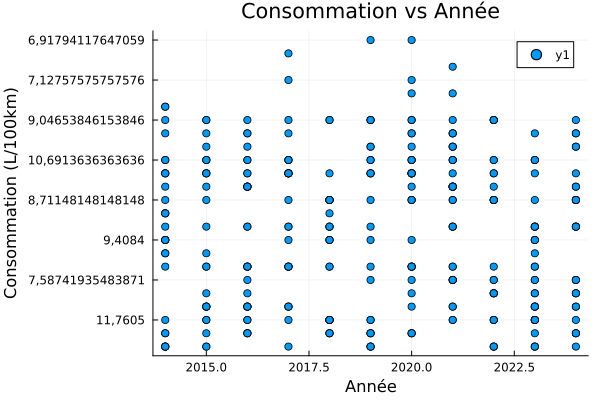

In [ ]:
# Résumé des données
println(describe(train))

# Visualisation de la consommation en fonction de l'année
scatter(train.annee, train.consommation, title="Consommation vs Année", xlabel="Année", ylabel="Consommation (L/100km)")


# 2. Prétraitement des données

In [35]:
data = deepcopy(train)
#data = dropmissing(data)

317×7 DataFrame
 Row │ annee  type                   nombre_cylindres  cylindree  transmission ⋯
     │ Int64  String31               Int64             String3    String15     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023  voiture_moyenne                       8  4,4        integrale    ⋯
   2 │  2020  VUS_petit                             4  2          integrale
   3 │  2021  voiture_compacte                      6  3,3        propulsion
   4 │  2023  voiture_deux_places                   8  5          integrale
   5 │  2022  voiture_moyenne                       8  4,4        integrale    ⋯
   6 │  2022  voiture_moyenne                       8  4,4        integrale
   7 │  2022  voiture_minicompacte                  3  1,5        traction
   8 │  2024  voiture_minicompacte                  3  1,5        traction
  ⋮  │   ⋮              ⋮                   ⋮              ⋮           ⋮       ⋱
 311 │  2016  voiture_moyenne                       6  3,5        integrale    ⋯
 312 │  2024  voiture_compacte                      4  2          integrale
 313 │  2022  VUS_petit                             4  2          traction
 314 │  2021  voiture_grande                        8  4,4        integrale
 315 │  2023  voiture_compacte                      6  3,3        propulsion   ⋯
 316 │  2019  voiture_minicompacte                  3  1,5        traction
 317 │  2017  VUS_petit                             4  2,4        traction
                                                  2 columns and 302 rows omitted

In [36]:
# Remplacer les virgules par des points dans 'cylindree'
data.cylindree = replace.(data.cylindree, "," => ".")

# Remplacer les virgules par des points dans 'consommation'
data.consommation = replace.(data.consommation, "," => ".")

317-element Vector{String}:
 "13.8358823529412"
 "9.80041666666667"
 "11.7605"
 "13.0672222222222"
 "13.8358823529412"
 "13.8358823529412"
 "7.3503125"
 "7.58741935483871"
 "11.2004761904762"
 "11.7605"
 ⋮
 "12.3794736842105"
 "9.80041666666667"
 "7.84033333333333"
 "8.71148148148148"
 "10.2265217391304"
 "12.3794736842105"
 "11.2004761904762"
 "7.84033333333333"
 "9.04653846153846"

In [71]:
function safe_parse_int(x)
    try
        parse(Int, x)
    catch
        missing
    end
end

safe_parse_int (generic function with 1 method)

In [37]:
function safe_parse_float(x)
    try
        return parse(Float64, x)
    catch
        return missing
    end
end

safe_parse_float (generic function with 1 method)

In [38]:
# Convertir 'cylindree' en Float64
data.cylindree = safe_parse_float.(data.cylindree)

# Convertir 'consommation' en Float64
data.consommation = safe_parse_float.(data.consommation)

317-element Vector{Float64}:
 13.8358823529412
  9.80041666666667
 11.7605
 13.0672222222222
 13.8358823529412
 13.8358823529412
  7.3503125
  7.58741935483871
 11.2004761904762
 11.7605
  ⋮
 12.3794736842105
  9.80041666666667
  7.84033333333333
  8.71148148148148
 10.2265217391304
 12.3794736842105
 11.2004761904762
  7.84033333333333
  9.04653846153846

In [39]:
# Résumé des données
println(describe(data))

7×7 DataFrame
 Row │ variable          mean     min          median   max                    nmissing  eltype   
     │ Symbol            Union…   Any          Union…   Any                    Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────────────────────────
   1 │ annee             2019.15  2014         2019.0   2024                          0  Int64
   2 │ type                       VUS_petit             voiture_sous_compacte         0  String31
   3 │ nombre_cylindres  5.25237  3            4.0      12                            0  Int64
   4 │ cylindree         2.86467  1.2          2.5      6.4                           0  Float64
   5 │ transmission               4x4                   traction                      0  String15
   6 │ boite                      automatique           manuelle                      0  String15
   7 │ consommation      10.2898  4.52327      10.2265  16.8007                       0  Float64


# Corrélation entre les variables

Matrice de corrélation :
[1.0 -0.2080829046196419 -0.22507170462114864 -0.21033424193286063; -0.2080829046196419 1.0 0.9459674028218671 0.8569696498409947; -0.22507170462114864 0.9459674028218671 1.0 0.85280334794806; -0.21033424193286063 0.8569696498409947 0.85280334794806 1.0]


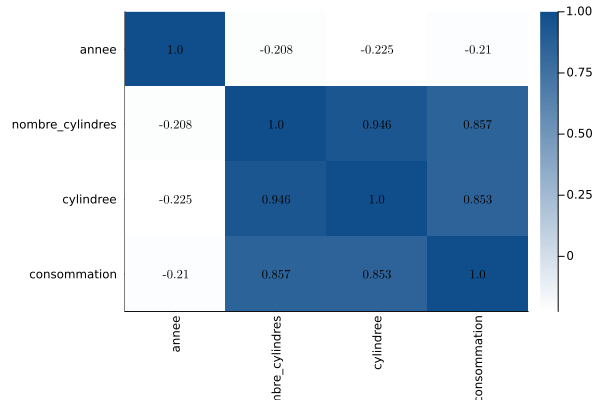

In [40]:
numeric_cols = [:annee, :nombre_cylindres, :cylindree, :consommation]

M = cor(Matrix(data[:, numeric_cols]))

# Afficher la matrice de corrélation
println("Matrice de corrélation :")
println(M)

# PLOT
(n,m) = size(M)
heatmap(M, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,numeric_cols), xrot=90, yticks=(1:m,numeric_cols), yflip=true)
annotate!([(j, i, text(round(M[i,j],digits=3), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])

1. `nombre_cylindres` et `cylindree` est très élevée, ce qui indique une forte relation positive. Cela suggère que le nombre de cylindres est fortement associé à la cylindrée des véhicules.

2. La corrélation entre `cylindree` et `consommation` est également élevée, montrant qu'une augmentation de la cylindrée est associée à une augmentation de la consommation (par exemple, les moteurs plus gros consomment plus de carburant).

3. Une corrélation similaire existe entre `nombre_cylindres` et `consommation`, ce qui est logique, car le nombre de cylindres et la cylindrée sont liés.

4. Les corrélations entre annee et les autres variables sont faibles et négatives, indiquant que les variables comme le nombre de cylindres, la cylindrée et la consommation ont légèrement diminué avec le temps.

## Consommation par type de véhicule

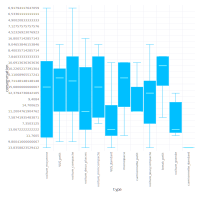

In [41]:
set_default_plot_size(20cm, 20cm)
Gadfly.plot(train, x=:type, y=:consommation, Geom.boxplot )

In [42]:
unique_categories = unique(skipmissing(data[:, :type]))
occurences = [sum(skipmissing(data[:, :type]) .== category) for category in unique_categories]
occurences = DataFrame(category = unique_categories, occurences = occurences)
occurences = occurences[occurences.occurences .> 10, :] #TODO INVESTIGATE 

7×2 DataFrame
 Row │ category               occurences 
     │ String31               Int64      
─────┼───────────────────────────────────
   1 │ voiture_moyenne                28
   2 │ VUS_petit                      86
   3 │ voiture_compacte               49
   4 │ voiture_deux_places            40
   5 │ voiture_minicompacte           17
   6 │ VUS_standard                   17
   7 │ voiture_sous_compacte          54

Consommation en fonction du type véhicule moyen :

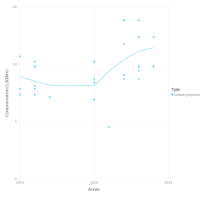

In [43]:
set_default_plot_size(20cm, 20cm)
vehicule_moyenne = filter(row -> row.type == "voiture_moyenne", data)
Gadfly.plot(vehicule_moyenne, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type VUS_petit

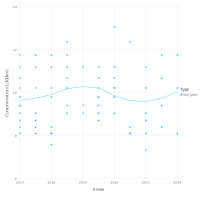

In [44]:
set_default_plot_size(20cm, 20cm)
vehicule_VUSp = filter(row -> row.type == "VUS_petit", data)
Gadfly.plot(vehicule_VUSp, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule compacte

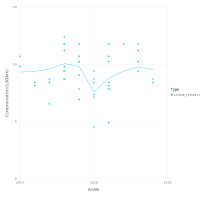

In [45]:
set_default_plot_size(20cm, 20cm)
voiture_compacte = filter(row -> row.type == "voiture_compacte", data)
Gadfly.plot(voiture_compacte, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule 2 places

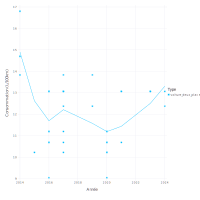

In [46]:
set_default_plot_size(20cm, 20cm)
voiture_deux_places = filter(row -> row.type == "voiture_deux_places", data)
Gadfly.plot(voiture_deux_places, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule camionnette standard

In [47]:
set_default_plot_size(20cm, 20cm)
camionnette_standard = filter(row -> row.type == "camionnette_standard", data)
Gadfly.plot(camionnette_standard, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Plot(...)

Consommation en fonction du type véhicule mini compacte

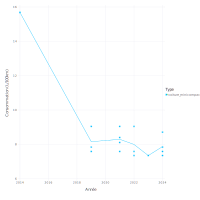

In [48]:
set_default_plot_size(20cm, 20cm)
voiture_minicompacte = filter(row -> row.type == "voiture_minicompacte", data)
Gadfly.plot(voiture_minicompacte, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule VUS standard

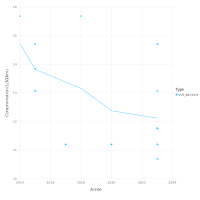

In [49]:
set_default_plot_size(20cm, 20cm)
VUS_standard = filter(row -> row.type == "VUS_standard", data)
Gadfly.plot(VUS_standard, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule sous-compacte

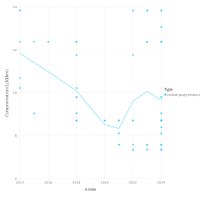

In [50]:
set_default_plot_size(20cm, 20cm)
voiture_sous_compacte = filter(row -> row.type == "voiture_sous_compacte", data)
Gadfly.plot(voiture_sous_compacte, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

# Régression linéaire

In [124]:
Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

first(train, 5)

5×7 DataFrame
 Row │ annee  type                 nombre_cylindres  cylindree  transmission   ⋯
     │ Int64  String31             Int64             String3    String15       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023  voiture_moyenne                     8  4,4        integrale      ⋯
   2 │  2020  VUS_petit                           4  2          integrale
   3 │  2021  voiture_compacte                    6  3,3        propulsion
   4 │  2023  voiture_deux_places                 8  5          integrale
   5 │  2022  voiture_moyenne                     8  4,4        integrale      ⋯
                                                               2 columns omitted

In [125]:
# Remplacer les virgules par des points
train.cylindree = replace.(train.cylindree, "," => ".")
valid.cylindree = replace.(valid.cylindree, "," => ".")
train.consommation = replace.(train.consommation, "," => ".")
valid.consommation = replace.(valid.consommation, "," => ".")

# Convertir 'cylindree' en Float64
train.cylindree = safe_parse_float.(train.cylindree)
valid.cylindree = safe_parse_float.(valid.cylindree)
train.consommation = safe_parse_float.(train.consommation)
valid.consommation = safe_parse_float.(valid.consommation)

79-element Vector{Float64}:
 12.3794736842105
  9.80041666666667
 10.6913636363636
  9.4084
 14.700625
  7.58741935483871
  8.71148148148148
 13.8358823529412
 12.3794736842105
 12.3794736842105
  ⋮
  8.71148148148148
  7.58741935483871
 10.2265217391304
 15.6806666666667
 11.7605
 12.3794736842105
 13.0672222222222
 10.2265217391304
 11.2004761904762

In [126]:
println(describe(train))

7×7 DataFrame
 Row │ variable          mean     min          median   max                    nmissing  eltype   
     │ Symbol            Union…   Any          Union…   Any                    Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────────────────────────
   1 │ annee             2019.15  2014         2019.0   2024                          0  Int64
   2 │ type                       VUS_petit             voiture_sous_compacte         0  String31
   3 │ nombre_cylindres  5.25237  3            4.0      12                            0  Int64
   4 │ cylindree         2.86467  1.2          2.5      6.4                           0  Float64
   5 │ transmission               4x4                   traction                      0  String15
   6 │ boite                      automatique           manuelle                      0  String15
   7 │ consommation      10.2898  4.52327      10.2265  16.8007                       0  Float64


In [127]:
#drop type, numbre cylindre, cylindree,
train = select(train, Not([:type, :transmission, :boite]))
valid = select(valid,  Not([:type, :transmission, :boite]))


79×4 DataFrame
 Row │ annee  nombre_cylindres  cylindree  consommation 
     │ Int64  Int64             Float64    Float64      
─────┼──────────────────────────────────────────────────
   1 │  2024                 8        4.4      12.3795
   2 │  2024                 6        3.0       9.80042
   3 │  2021                 6        3.0      10.6914
   4 │  2018                 4        2.0       9.4084
   5 │  2015                 8        6.2      14.7006
   6 │  2021                 4        2.0       7.58742
   7 │  2018                 4        2.0       8.71148
   8 │  2014                 8        4.8      13.8359
  ⋮  │   ⋮           ⋮              ⋮           ⋮
  73 │  2017                 4        2.4      10.2265
  74 │  2019                 8        6.2      15.6807
  75 │  2023                 6        3.3      11.7605
  76 │  2023                 8        5.0      12.3795
  77 │  2024                 8        5.0      13.0672
  78 │  2019                 6        3.5      10.2265
  79 │  2022                 6        3.3      11.2005
                                         64 rows omitted

In [ ]:
model = GLM.lm(@formula(consommation ~ annee + cylindree + nombre_cylindres), train)
# Prediction avec l'ensemble de validation
valid_prediction = GLM.predict(model, valid)
# Trouver la moyenne de prediction
mean_prediction = mean(valid_prediction)
# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)
# Transformer les predictions en valeur entiere
v = Int.(round.(valid_prediction, digits=0))
# Calculer le RMSE
rmse = sqrt(mean((v - valid.consommation).^2))
println("RMSE: ", rmse)

RMSE: 1.0900046016392788
